<a href="https://colab.research.google.com/github/davis689/binder/blob/master/Solving_the_Schrodinger_Equation_Numerically_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerically Solving the Schrödinger Equation

The number of problems for which we will be able to find an analytical solution to the Schrödinger equation is limited. We have seen how to solve the particle in a box and we will be able to analytically solve some others but even in those cases we often rely on solutions by long dead French mathematicians rather than doing the tedious work ourselves. 

We should use the cases in which we can find a precise solution to develop our intuition about what a reasonable solution looks like and be able to make informed qualitative guesses at what a good wavefunction will be. But it would also be useful to know techniques in calculating the wavefunctions and energies numerically. Here our answers may not be precise but we with enough work we should be able to approach the true answer as closely as we want.

We have seen the Schrödinger Equation written as a differential equation and we have seen that it forms an eigenfunction/eigenvalue equation. 
$$ -\frac{\hbar^2}{2m}\frac{d^2}{d x^2} \psi(x) + V(x)\psi(x) = E\psi(x)$$

Here we will see how to transform the equation into a matrix equation that preserves the eigenfunction/eigenvalue form (where the term $eigenfunction$ is replaced by $eigenvector$). 


## Method
The method we will use here is called the ["Finite Difference Method"](https://en.wikipedia.org/wiki/Finite_difference_method) (see the linked Wikipedia article). In this method we will turn the function $\psi(x)$ into a vector, which is a list in Python, and the operator of the differential equation into a *matrix*. We then end up with a matrix eigenequation, which we can diagonalize to get our answer.

### Discretization
The process of discretization is simply turning our continuous space $x$, into a discrete number of steps, $N$, and our function $\psi(x)$ into an array of size $N$. We thus have $N$ values $x_i$, which have a stepsize $h = \Delta x = x_{i+1} - x_i$. Our choice of the *size* of our space, $N$, turns out to be important. Too large a number will slow down our computation and require too much computer memory, too small a number and the answers we compute will not be sufficiently accurate. A common practice is to start with a small number $N$ and then increase it until the accuracy is acceptable. The actual value you obtain in the end will depend on the problem you are studying. 

### first order differential
We first need to develop how we will take the derivative of our function. Going back to our introduction to calculus, we remember that the derivative was defined as:
$$
\frac{d}{dx} f(x) = \lim_{\Delta x \rightarrow 0} \frac{f(x+\Delta x) - f(x)}{\Delta x} \approx \frac{f(x+h) - f(x)}{h} + \mathrm{O}(h)
$$
When we take a *finite difference*, we simply not take the limit all the way down to 0, but stop at $\Delta x = h$. Note that for this equation we evaluate the point just *after* $x$, which we call the *forward difference*. There are other possible ways to do a finite difference but we won't concern ourselves with them here.

Note that for this approximation to a derivative, we have a problem at the end of our space. In our case, $x+\Delta x$ is not defined at the last point. To account for this, we'll have to ignore the last point of our derivative.

#### Matrix representation
Matrix and vector methods are very straightforward to implement using a computer. We need to see how a matrix can be setup to take a derivative. I expect that many of you will not have taken linear algebra and we won't need to concern ourselves too much with each detail of the matrix but you should be able to see the main point. 

#####Matrix Multiplication
If you have not taken linear algebra it will be useful to see the mechanics of multplication of a small matrix with a vector. We will use a 3x3 matrix, $O$ (for $operator$) and a 3x1 vector, $f$ (for $function$) as examples. 
$$O=\begin{bmatrix}1&0&3\\0&5&4\\2&6&0\end{bmatrix}\,\,\,\,\,\,\,\,\,\,\,f=\begin{bmatrix} 1\\2\\3\end{bmatrix}$$
Multiplication of the vector by the matrix leads to a 3x1 vector. The first element comes from the sum of the top leftmost element multiplied by the first element of the vector, the top-center element multiplied of the matrix by the second element of the vector and the top rightmost element of the matrix multiplied by the last element of the vector. In other words the first element of the product is the sum of the elemnts on the first row of the matrix multiplied by the first (only) column of the vector.

$$Of=\begin{bmatrix}1&0&3\\0&5&4\\2&6&0\end{bmatrix}\begin{bmatrix} 1\\2\\3\end{bmatrix}=\begin{bmatrix}1\cdot1+0\cdot2+3\cdot3\\0\cdot1+5\cdot2+4\cdot3\\2\cdot1+6\cdot2+0\cdot3\end{bmatrix}=\begin{bmatrix}10\\22\\14\end{bmatrix}$$
In this case our vector is not an eigenvector of the matrix because it doesn't emerge from the multiplication as a constant times the original vector.
Multiplying two matrices is similar but we won't worry about that now.

We can do this matrix multiplication in python too.

In [2]:
import numpy as np # load package needed for dealing with matrices and numerical calculations.
import matplotlib.pyplot as plt

O=np.array([[1,0,3],[0,5,4],[2,6,0]])
#print(O) # if you want to see O, remove the first # and run the cell
f=np.array([[1],[2],[3]])
O.dot(f) # np.dot(O,f) works too

array([[10],
       [22],
       [14]])

Try multiplying $$\begin{bmatrix} 1&-1&0\\-1&1&-1\\ 0&-1&1\end{bmatrix}$$ by $$\begin{bmatrix}2\\3\\1\end{bmatrix}$$

In our case, our matrices and vectors may have hundreds of elements. We'll want to find a matrix that can turn our vector representation of $\psi$ into its derivative.
We now want to turn the equation into a matrix equation for us to evaluate. If you just want to take the derivative of a function stored in an array, then this is not needed, you can run a loop and evaluate the equation for each $x_i$, but if you want to solve a differential equation, we need the matrix.

We introduce the vectors $f(x) = [f_0,f_1,f_2,...,f_{N-1}]$ and for the derivative $f'(x) = [f'_0,f'_1,f'_2...,f'_{N-1}]$. The forward difference derivative can then be written as:
$$ f'_i = (f_{i+1} - f_i)/h $$
And the matrix equation for the forward difference derivative is just:
$$
\begin{pmatrix}f'_0 \\ f'_1 \\\vdots \\ f'_{N-1}\end{pmatrix} = \frac{1}{h}\begin{pmatrix}f_1-f_0\\f_2-f_1\\\vdots\\f_{N}-f_{N-1}\end{pmatrix}= \frac{1}{h}
\begin{pmatrix} -1 & 1 & 0 & & \\ 0 & -1 & 1 & & \\ & & \ddots & \ddots \\
& & & -1 & \end{pmatrix}\begin{pmatrix}f_0 \\ f_1 \\\vdots \\ f_{N-1}\end{pmatrix}
$$
We note that the last entry in the matrix will not be correct because there is no element for $N$. We can fix this up by taking the *backward* derivative at the last point.

We now check that this works. Using Python and Numpy we will take the derivative of $\sin(x)$ and plot the result.
First we tell the system we want to use the Numpy package to deal with numerical calculations and the matplotlib package to deal with making plots.
Then setup some parameters such as number of points, the $x$-axis range, etc.

## Example derivative calculation
### Small matrices
We'll calculate the derivative using a matrix like the one above of $y=2x$ over some small range of $x$ as a way of testing the technique while using functions 

[[-1.  1.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0. -1.  1.]
 [ 0.  0.  0.  0.  0. -1.]]
[2. 2. 2. 2. 2.]


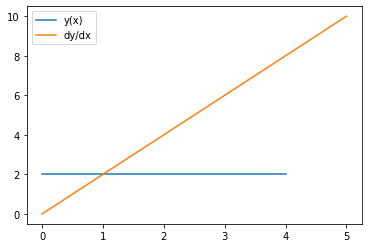

In [3]:
N=6
x=np.linspace(0,5,N)
h = x[1]-x[0]
y=2*x # change this to 

D=1/h*(np.diag(-1*np.ones(N),0)+np.diag(np.ones(N-1),1))
print(D*h) # multiply by Δx to see the matrix itself. Divide by Δx to get the proper slope.

yprime=D.dot(y)
print(yprime[:-1]) #exclude the last point since there is no following point to subtract

plt.plot(x[:-1],yprime[:-1],label='y(x)')
plt.plot(x,y,label='dy/dx')
plt.legend()
plt.show()


You should see that the derivative is a constant, 2. 

Try changing $y(x)$ to $x^2$ (which you express in python as ```x**2```). The derivative here should still be linear but with a non-zero slope. 

Try $y(x)=x^3$. You should notice that the curves are made up of line segments. Increasing the value of $N$ will create smoother curves and a more accurate derivative. Try N=50.

Now try $y(x)=sin(x)$. Type ```np.sin(x)``` to get the $sin$ function since it comes from the numpy library.

## Second order Differential
We can now extend this method to the second order differential. If we take the backward differential of the result of a forward differential, we get:
$$
\frac{d^2}{dx^2}f(x) = \lim_{\Delta x \rightarrow 0} \frac{f'(x)-f'(x-\Delta x)}{\Delta x} =  \lim_{\Delta x \rightarrow 0} \frac{f(x+\Delta x) - f(x) - (f(x) - f(x-\Delta x))}{\Delta x^2} \\
\frac{d^2}{dx^2}f(x) = \lim_{\Delta x \rightarrow 0} \frac{f(x+\Delta x) - 2f(x) + f(x-\Delta x))}{\Delta x^2} \approx \frac{f(x+h) - 2f(x) + f(x-h))}{h^2}
$$
So in the discrete space we can write this as:
$$ f''_i = (f_{i+1} - 2f_i + f_{i-1})/h^2 $$
And finally, as a matrix equation, the second derivative is then:
$$
\begin{pmatrix}f''_0 \\ f''_1 \\ f''_2 \\\vdots \\ f''_{N-1}\end{pmatrix} = \frac{1}{h^2}
\begin{pmatrix} -2 & 1 & 0 & 0 & \\ 1 & -2 & 1 & 0 & \\ 
0& 1 & -2 & 1 &  \\ &  & \ddots & \ddots & \ddots &\\
&  & & 1 & -2 \end{pmatrix}\begin{pmatrix}f_0 \\ f_1 \\ f_2 \\\vdots \\ f_{N-1}\end{pmatrix}
$$
Where now we note that at both ends of our array we will get an inaccurate answer unless we do some fixup. The fixup in this case is to use the same elements as the row below (at the start) or the row above (at the end), so we get $f''_0 = f''_1$ and $f''_{N-1} = f''_{N-2}$, which is not great but better than the alternative.

We can now try this matrix in Python and compute the second derivative of our $y(x)$ array.

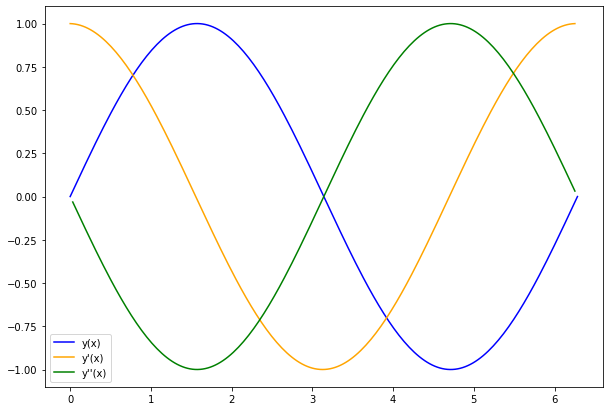

In [4]:
N=200
x=np.linspace(0,2*np.pi,N)
h=x[1]-x[0]
y=np.sin(x)


D1=1/h*(np.diag(-1*np.ones(N),0)+np.diag(np.ones(N-1),1))

D2 = 1./(h**2)*(np.diag(np.ones(N-1),-1) + np.diag( -2.*np.ones(N),0) + np.diag(np.ones(N-1),1))
                # The first np.diag() puts (N-1) ones on the partial diagonal below the diagonal (,-1)
                # The second puts N negative twos on the diagonal. The third puts (N-1) ones on the partial diagonal above the diagonal (,1).
yp=D1.dot(y)
ypp = D2.dot(y) # 'operate' second derivative matrix on function, y.

plt.figure(figsize=(10,7))
plt.plot(x,y,label='y(x)',color='blue')
plt.plot(x[:-1],yp[:-1],label='y\'(x)',color='orange')     # Last value is invalid, don't plot
plt.plot(x[1:-1],ypp[1:-1],label='y\'\'(x)',color='green')  # First and last value is invalid.
plt.legend()
plt.show()

# Solving the Particle in a Box Schrödinger Equation

We can now setup the Schrodinger Equation as a matrix equation:
$$
\hat H = \frac{\hbar^2}{2m}\frac{d^2}{d x^2} + V \\
\hat H \psi(x) = E \psi(x)
$$
We now know the matrix for taking the second order derivative. The matrix for the potential is simply the values of the potential on the diagonal of the matrix: $\mathbf{V}_{i=j} = V_i$. 

Writing out the matrix for $\mathbf{H}$ we get:
$$
\mathbf{H} = \frac{-\hbar^2}{2 m h^2} \begin{pmatrix} -2 & 1 & 0 & 0 & \\ 1 & -2 & 1 & 0 & \\ 
0& 1 & -2 & 1 &  \\ &  & \ddots & \ddots & \ddots &\\
&  & & 1 & -2 \end{pmatrix} + 
\begin{pmatrix} V_0 & 0 & 0 & & \\ 0 & V_1 & 0 & & \\ 0 & 0 & V_2 & & \\ & & &\ddots & \\ &&&&V_{N-1}\end{pmatrix}
$$ 

It is worth looking at the matrix of the Hamiltonian and notice the symmetry: $\mathbf{H}^T = \mathbf{H}$, so the transpose of the matrix is identical to the matrix. Since the matrix is *real* everywhere, the complex conjugate is also the same: $\mathbf{H}^*=\mathbf{H}$. Combining these two statements, we can say that the Hamiltonian is Hermetian: $\mathbf{H}^\dagger = \mathbf{H}$. We will come back to this later in the course.



### Infinite Square Well
The very simplest system to solve for is the infinite square well, for which $V=0$. We will readily recognize the results as alternating $\cos(x)$ and $\sin(x)$ functions, and the energy levels are:
$$
E_i = \frac{n^2\pi^2\hbar^2}{2ma^2}
$$
First, we need to discuss a subtlety. The Infinite Square Well from $-a/2$ to $a/2$ has $V=\infty$ *at* these points. We get into trouble trying to enter $\infty$ in our potential, so what we need to do is just limit the computational space from $-a/2+h$ to $a/2-h$, where $h$ is our step size. That way we force the wavefunction to zero at the end points. 
We compute this in the next box. I create $x_{full}$ as the full x-axis from $-a/2$ to $a/2$, but take $N+2$ steps. I then leave out the first and last point when calculating the wavefunctions. At the end, before plotting, I add a zero to the beginning and end of the wavefunctions, so that we get the expected result for plotting.

Note I again import everything and setup all the definitions, so this block is stand-alone, and can be copy-pasted into another notebook. Here we set up constants and import the library needed for dealing with linear algebra.

In [5]:
hbar=1 # use atomic units
m=1 # electron mass
N = 1000 
a = 1.0 # this doesn't matter unless we want to compare different size boxes.
x = np.linspace(-a/2.,a/2.,N)
# We want to store step size, this is the reliable way:
h = x[1]-x[0] # Should be equal to 2*np.pi/(N-1). This is delta x.
nl= 8 # the number of levels to calculate. Change this as you wish.

Now we set up the potential energy, the second derivative operator, and the Hamiltonian. Then extract the eigenvalues and eigenfunctions.

In [6]:
V = 0.*x # could be just zero but put x here to show that it is a function of x.
Mdd = 1./(h*h)*(np.diag(np.ones(N-1),-1) -2* np.diag(np.ones(N),0) + np.diag(np.ones(N-1),1)) # derivative operator
H = -(hbar*hbar)/(2.0*m)*Mdd + np.diag(V)  # Hamiltonian including derivative and potential energy.


E,psiT = np.linalg.eigh(H) # This computes the eigenvalues and eigenvectors
psi = np.transpose(psiT)   # We take the transpose of psiT to the wavefunction vectors can accessed as psi[n]

The energies are stored in $E$. The first $N$ levels are calculated. We will focus on only a few of them. Let's list the first several in atomic energy units.

In [7]:
for i in range(nl):
  print("E_{}={:8.3f}".format(i+1,E[i])) # the notation here is strange. Basically we will print everything between the "" 
                                          #but stuff between the brackets will get subsitututed in from the between the parentheses in .format()
                                          #So here we'll print i+1 which is the quantum number 'n' in the particle in a box and the energies.
                                          #The :8.3f stuff indicates how many places to use for the whole number (some may be spaces) and how many for the 
                                          #after the decimal point. The 'f' indicates a floating point (or decimal number). If we don't care about the 
                                          #format of the number that is displayed or if the number is a whole number as it is, like 'i', just {} is fine.

E_1=   4.915
E_2=  19.660
E_3=  44.236
E_4=  78.641
E_5= 122.875
E_6= 176.938
E_7= 240.830
E_8= 314.550


###Scaling the energies
The energy of the lowest level in a particle in a box is $\frac{n^2 \hbar^2 \pi^2}{2 m a^2}$. For convenience we will rescale the energies to be relative to the energy of the first level. So $\epsilon=\frac{E_n}{E_1}=\frac{E_n}{\frac{\hbar^2 \pi^2}{2ma^2}}=\frac{E_n}{\frac{\pi^2}{2}}=\frac{2E_n}{\pi^2}$ and $ϵ=\frac{E_n}{\frac{\hbar^2 \pi^2}{2ma^2}}=\dfrac{\frac{n^2 \hbar^2 \pi^2}{2ma^2}}{\frac{\hbar^2 \pi^2}{2ma^2}}=n^2$. So we can rescale the energy by multiplying by $2/\pi^2$ and the resulting value should be the quantum number squared. This makes it easy to see at a glance how close our numerical approximate answer is the analytical answer.

In [8]:
ϵ=[E[i]*2/np.pi**2 for i in range(nl)]
for i in range(nl):
  print("ϵ_{}={:>8.3f}".format(i+1,ϵ[i]))

ϵ_1=   0.996
ϵ_2=   3.984
ϵ_3=   8.964
ϵ_4=  15.936
ϵ_5=  24.900
ϵ_6=  35.855
ϵ_7=  48.802
ϵ_8=  63.741


Our calculation gives almost what we expect. Each energy is essentially $n^2$ as it should be. If you change $N$ above and re-run the cells, you can see what affect using fewer (or more) points will have on runtime and accuracy. Try N=100 and N=5000. Remember that our calculation uses an N by N matrix so N=5000 will have to deal with a 25,000,000 element matrix.

We now want to plot the wavefunctions. We can plot individual wavefunctions using matplotlib (abbreviated as $plt$) and the $x$ and $psi$ lists we made above. For instance,
```
plt.plot(x,psi[2])
```
will the wavefunction corresponding to $n=3$ (remember we start counting at 0, so $n=1$ corresponds to psi[0]).

Try plotting several of the wavefunctions below. Do they match what you think they should look like?

You can beautify your graphs by adding axis labels and a title. 

```
plt.xlabel('x')
plt.ylabel('$\psi$')
plt.title('Particle in an infinite box wavefunction')
```
If you just type the lines shown here, some strange symbols will appear above the graph. Use ```plt.show()``` at the end and these go away.


We'll set up a mechanism to plot a bunch of wavefunctions at the same time.

The sign of the wavefunctions as we approach the ends is arbitrary. We can make it consistent if we want. The $for$ loop below plots each wavefunction but it also makes it so that the left end points all approach zero from above. The right end points then alternate.

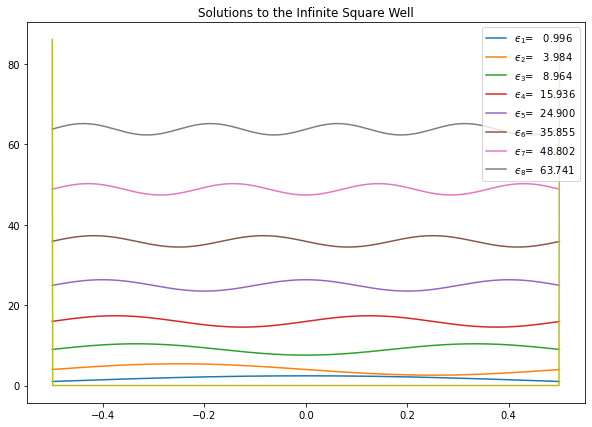

In [9]:
plt.figure(figsize=(10,7))
for i in range(1,nl+1): # start with i=1 and go to i=
    if psi[i-1][10] < 0:   # Flip the wavefunctions if it is negative at large x, so plots are more consistent.
        plt.plot(x,-psi[i-1]/np.sqrt(h)*np.sqrt(1)+ϵ[i-1],label="$ϵ_{}$={:>8.3f}".format(i,ϵ[i-1]))
    else:
        plt.plot(x,psi[i-1]/np.sqrt(h)*np.sqrt(1)+ϵ[i-1],label="$ϵ_{}$={:>8.3f}".format(i,ϵ[i-1]))
    plt.title("Solutions to the Infinite Square Well")   
V_x = np.zeros([N],float) # potential energy is just zeros. We don't need it for calculating but we do for plotting
for i in range(N): # but adjust potential energy at the ends where it is infinite
    if x[i] == -a/2 or x[i]==a/2:
        V_x[i]=1.35*ϵ[nl-1] # we can't plot ininity but extend the box to 135% of the highest plotted energy level
plt.plot(x,V_x)  
plt.legend()
plt.savefig("Infinite_Square_Well_WaveFunctions.pdf")
plt.show()

We now also want to check that the energy levels do indeed correspond to the known levels:
$$
E_n = \frac{n^2 \pi^2 \hbar^2}{2 m a^2}
$$

In [10]:
for i in range(nl):
    n = i+1
    print("ϵ[{}] = {:9.4f},     ϵ_{} ={:9.4f},      %deviation={:>8.4f}%".format(n,ϵ[i],n, n*n,((ϵ[i]-n*n)/n/n)))

ϵ[1] =    0.9960,     ϵ_1 =   1.0000,      %deviation= -0.0040%
ϵ[2] =    3.9840,     ϵ_2 =   4.0000,      %deviation= -0.0040%
ϵ[3] =    8.9640,     ϵ_3 =   9.0000,      %deviation= -0.0040%
ϵ[4] =   15.9359,     ϵ_4 =  16.0000,      %deviation= -0.0040%
ϵ[5] =   24.8997,     ϵ_5 =  25.0000,      %deviation= -0.0040%
ϵ[6] =   35.8552,     ϵ_6 =  36.0000,      %deviation= -0.0040%
ϵ[7] =   48.8024,     ϵ_7 =  49.0000,      %deviation= -0.0040%
ϵ[8] =   63.7412,     ϵ_8 =  64.0000,      %deviation= -0.0040%


A final test shows the accuracy of our calculation in the orthonormality of the states:

In [11]:
norm=[np.sqrt(1/np.trapz(psi[i]**2,x)) for i in range(nl)] # calculate normalization for each eigenfunction
psi_norm=[psi[i]*norm[i] for i in range(nl)] # normalize psi
np.trapz(psi_norm[1]**2,x) # check that it works for one psi

1.0

The code above checks the normalization of the n=2 eigenfunctions. We can check the orthonormality of a range of levels using the following lines.

In [12]:
for j in range(nl):
    for i in range(nl):
        print("ψ_{}, ψ_{}, {:2.2f}".format(i+1,j+1,np.trapz(psi_norm[i]*psi_norm[j],x)))

ψ_1, ψ_1, 1.00
ψ_2, ψ_1, 0.00
ψ_3, ψ_1, -0.00
ψ_4, ψ_1, 0.00
ψ_5, ψ_1, 0.00
ψ_6, ψ_1, -0.00
ψ_7, ψ_1, 0.00
ψ_8, ψ_1, 0.00
ψ_1, ψ_2, 0.00
ψ_2, ψ_2, 1.00
ψ_3, ψ_2, -0.00
ψ_4, ψ_2, 0.00
ψ_5, ψ_2, 0.00
ψ_6, ψ_2, -0.00
ψ_7, ψ_2, 0.00
ψ_8, ψ_2, 0.00
ψ_1, ψ_3, -0.00
ψ_2, ψ_3, -0.00
ψ_3, ψ_3, 1.00
ψ_4, ψ_3, 0.00
ψ_5, ψ_3, 0.00
ψ_6, ψ_3, -0.00
ψ_7, ψ_3, 0.00
ψ_8, ψ_3, 0.00
ψ_1, ψ_4, 0.00
ψ_2, ψ_4, 0.00
ψ_3, ψ_4, 0.00
ψ_4, ψ_4, 1.00
ψ_5, ψ_4, 0.00
ψ_6, ψ_4, 0.00
ψ_7, ψ_4, -0.00
ψ_8, ψ_4, -0.00
ψ_1, ψ_5, 0.00
ψ_2, ψ_5, 0.00
ψ_3, ψ_5, 0.00
ψ_4, ψ_5, 0.00
ψ_5, ψ_5, 1.00
ψ_6, ψ_5, 0.00
ψ_7, ψ_5, -0.00
ψ_8, ψ_5, 0.00
ψ_1, ψ_6, -0.00
ψ_2, ψ_6, -0.00
ψ_3, ψ_6, -0.00
ψ_4, ψ_6, 0.00
ψ_5, ψ_6, 0.00
ψ_6, ψ_6, 1.00
ψ_7, ψ_6, -0.00
ψ_8, ψ_6, 0.00
ψ_1, ψ_7, 0.00
ψ_2, ψ_7, 0.00
ψ_3, ψ_7, 0.00
ψ_4, ψ_7, -0.00
ψ_5, ψ_7, -0.00
ψ_6, ψ_7, -0.00
ψ_7, ψ_7, 1.00
ψ_8, ψ_7, 0.00
ψ_1, ψ_8, 0.00
ψ_2, ψ_8, 0.00
ψ_3, ψ_8, 0.00
ψ_4, ψ_8, -0.00
ψ_5, ψ_8, 0.00
ψ_6, ψ_8, 0.00
ψ_7, ψ_8, 0.00
ψ_8, ψ_8, 1.00


Explain the results in terms of orthonormality.




# Particle in a larger box

Let's compare that to a particle in a box that is twice as large. Again we will calculate energies relative to the lowest level in the original box.

We set up variables the same way as before. (We don't really need to redefine variables if they're not changing but it's more clear this way.)

In [13]:
hbar=1 # use atomic units
m=1 # electron mass
N = 1000 
a2 = 2 # the width now is twice what it was before.
x = np.linspace(-a2/2.,a2/2.,N)
# We want to store step size, this is the reliable way:
h = x[1]-x[0] # Should be equal to 2*np.pi/(N-1). This is delta x.
nl= 5 # the number of levels to calculate

The operators will be the same as before.


In [14]:
V = 0.*x # could be just zero but put x here to show that it is a function of x.
Mdd = 1./(h*h)*(np.diag(np.ones(N-1),-1) -2* np.diag(np.ones(N),0) + np.diag(np.ones(N-1),1)) # derivative operator
H = -(hbar*hbar)/(2.0*m)*Mdd + np.diag(V)  # Hamiltonian including derivative and potential energy.


E2,psiT = np.linalg.eigh(H) # This computes the eigenvalues and eigenvectors
psi = np.transpose(psiT)   # We take the transpose of psiT to the wavefunction vectors can accessed as psi[n]

In [15]:
ϵ2=[E2[i]*2/np.pi**2 for i in range(nl)]
print("energy level       energy in original box       energy in 2x box       ratio")
for i in range(nl):
  print("ϵ_{}=            {:>8.3f}                     {:>8.3f}               {:>8.3f}".format(i+1,ϵ[i],ϵ2[i],ϵ[i]/ϵ2[i]))

energy level       energy in original box       energy in 2x box       ratio
ϵ_1=               0.996                        0.249                  4.000
ϵ_2=               3.984                        0.996                  4.000
ϵ_3=               8.964                        2.241                  4.000
ϵ_4=              15.936                        3.984                  4.000
ϵ_5=              24.900                        6.225                  4.000


Do these results make sense? Explain.


Without calculating, would happen if the box were 1/2 as wide as the original box? Calculate it.


# Particle in a finite box

Now we turn our attention to a problem without an easy analytical solution.
The particle in a finite box is a similar problem but the box doesn't have infinite sides. 

In [16]:
hbar=1 # Planck's constant in atomic units.
m=1 # mass of electron
N = 2047 # number of points to calculate
a = 1.0 # width of finite box
b=8 # total width of system
V0=400 #potential energy in atomic units
nl=7 #number of levels to calculate
x = np.linspace(-b/2.,b/2.,N) # x-coordinate 
rgtlimit=np.searchsorted(x,[a/2])[0] # find the index of the right edge of the box to be used in integration later.
#searchsorted used here looks through x and finds the value closest to a/2.
# We want to store step size, this is the reliable way:
h = x[1]-x[0] # Should be equal to 2*np.pi/(N-1)

Now we set up the potential. Here we want the potential to be zero between a/2 and -a/2 and $V_0$ outside that range. 

In [17]:
V=[]
for i in x:
  if i<-a/2 or i>a/2:
    V.append(V0)
  else:
    V.append(0)
#print(V)

Now setup the operators and calculate. Everything is the same here 

In [18]:
Mdd = 1./(h*h)*(np.diag(np.ones(N-1),-1) -2* np.diag(np.ones(N),0) + np.diag(np.ones(N-1),1))
H = -(hbar*hbar)/(2.0*m)*Mdd + np.diag(V) 
Ef,psiT = np.linalg.eigh(H) # This computes the eigen values and eigenvectors
psi = np.transpose(psiT)  # We take the transpose of psiT to the wavefunction vectors can accessed as psi[n]
norm=[np.sqrt(1/np.trapz(psi[i]**2,x)) for i in range(nl)] #calcluate normalization coefficient. Should be same but no cost to calculate for each level.
Ef=Ef/np.pi**2*2 # scale energy relative to standard particle in an infinite box
V=[V/np.pi**2*2 for V in V] # same for potential energy.

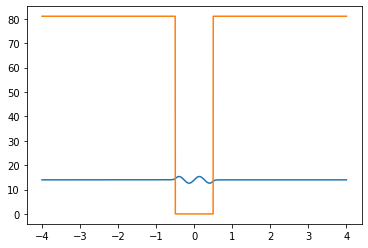

In [19]:
psi_norm=[psi[i]*norm[i] for i in range(nl)] # normalize 
plt.plot(x,psi_norm[3]+Ef[3])# plot second wavefunction to make sure it looks right.
plt.plot(x,V)
plt.show()

Check to make sure the wavefunctions are normalized.

As before, let's plot several wavefunctions on the same graph offset by their energies. It should be emphasized that all particles are travelling only on the $x$-axis. Offsetting along the $y$-axis only gets them out of each other's way and shows where the energy levels are.

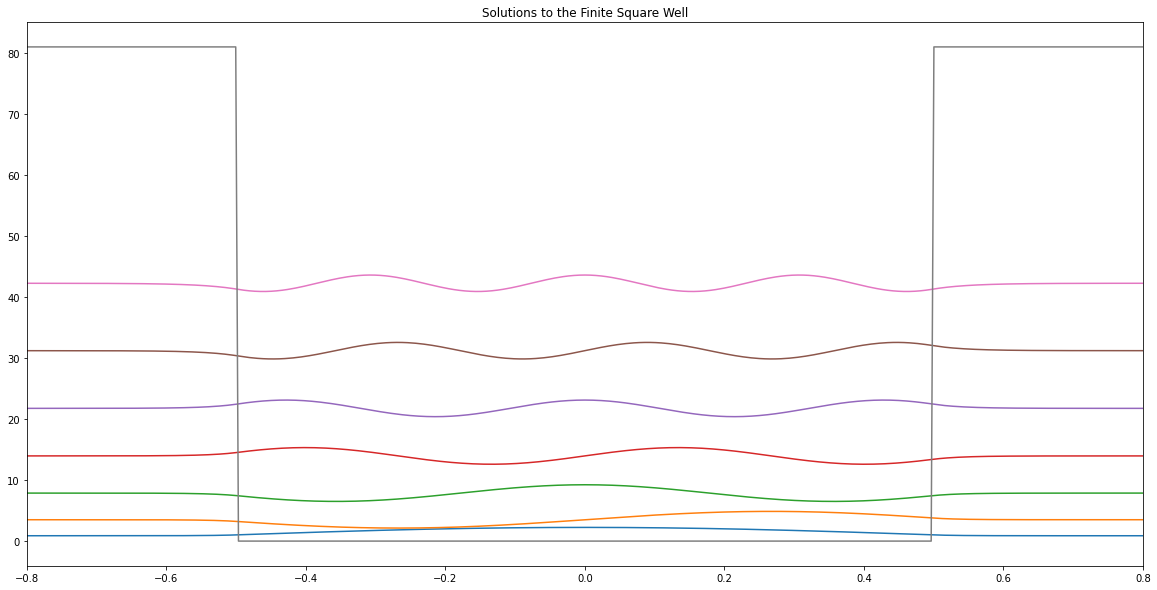

In [20]:
#plot several wavefunctions on same graph with potential. Each one placed at its energy level.
fact=1 #scale factor for nice plotting. 1 does nothing but if the plots need to be scaled up or down, change it.
plt.figure(figsize=(20,10))
for i in range(nl):
    if psi[i][50] < 0:   # Flip the wavefunctions if it is negative at small x, so plots are more consistent.
        plt.plot(x,-psi_norm[i]*fact+Ef[i],label="$E_{}$={:>8.3f}".format(i+1,Ef[i]))
    else:
        plt.plot(x,psi_norm[i]*fact+Ef[i],label="$E_{}$={:>8.3f}".format(i+1,Ef[i]))
    plt.title("Solutions to the Finite Square Well")

plt.plot(x,V)
plt.xlim(-a*.8,a*.8)
#plt.legend()
#plt.savefig("Finite_Square_Well_WaveFunctions.pdf")
plt.show()


Do the same thing for the square of the wavefunction.

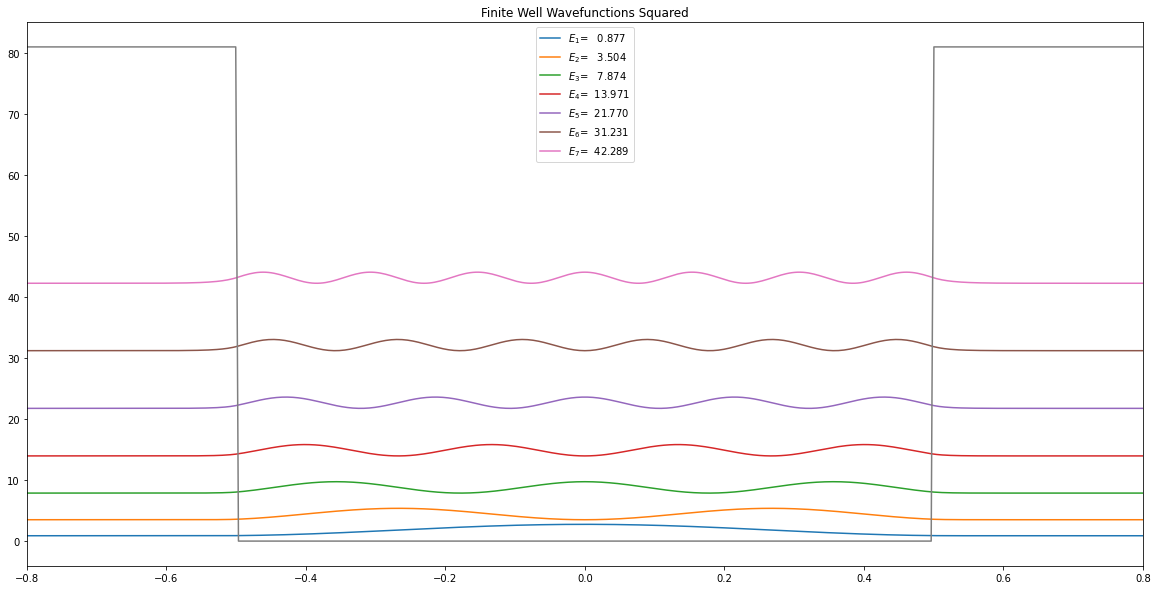

In [21]:
#plot square of wavefunction
plt.figure(figsize=(20,10))
for i in range(nl):
    plt.plot(x,psi_norm[i]**2*fact**2+Ef[i],label="$E_{}$={:>8.3f}".format(i+1,Ef[i]))
plt.title("Finite Well Wavefunctions Squared")
plt.plot(x,V)
plt.legend()
plt.xlim(-.8*a,.8*a)
#plt.savefig("Finite_Square_Well_WaveFunctions_Squared.pdf")
plt.show()

In [22]:
ϵ2=[Ef[i]*2/np.pi**2 for i in range(nl)]
print("energy level       energy in original box       energy in 2x box       ratio")
for i in range(nl):
  print("ϵ_{}=            {:>8.3f}                     {:>8.3f}               {:>8.3f}".format(i+1,ϵ[i],Ef[i],Ef[i]/ϵ[i]))

energy level       energy in original box       energy in 2x box       ratio
ϵ_1=               0.996                        0.877                  0.880
ϵ_2=               3.984                        3.504                  0.880
ϵ_3=               8.964                        7.874                  0.878
ϵ_4=              15.936                       13.971                  0.877
ϵ_5=              24.900                       21.770                  0.874
ϵ_6=              35.855                       31.231                  0.871
ϵ_7=              48.802                       42.289                  0.867


We can see that $\psi$ does not go to zero at the end of the box the way that it did in the infinite box. This is especially noticeable for the higher levels. We can integrate $\psi$ from a/2 to b (i.e. the region on the right outside the box) and multiply by 2 to get the total area on both sides. The $trapz$ integration function for numerical trapezoidal integration takes for arguments $y$ and $x$. In our case we'll take $psi$ for the $i$th level from the right boundary to the end (psi[i][rgtlimit:]) and square it, normalize it, and integrate. 

In [23]:
outob=[np.trapz((psi_norm[i][rgtlimit:])**2,x[rgtlimit:])*2 for i in range(0,nl)] #integrate from the right edge of the box to 'infinity' and multipy by 2 to account for both sides
for i in range(1,nl+1):
      print("n={}, E[{}] = {:9.4f},         Probability to be outside box={:9.3f}".format(i,i,E[i-1],outob[i-1]))

n=1, E[1] =    4.9151,         Probability to be outside box=    0.001
n=2, E[2] =   19.6603,         Probability to be outside box=    0.003
n=3, E[3] =   44.2356,         Probability to be outside box=    0.006
n=4, E[4] =   78.6406,         Probability to be outside box=    0.011
n=5, E[5] =  122.8750,         Probability to be outside box=    0.019
n=6, E[6] =  176.9385,         Probability to be outside box=    0.029
n=7, E[7] =  240.8303,         Probability to be outside box=    0.045


In [54]:
hbar=1 # Planck's constant in atomic units.
m=1 # mass of electron
N = 2047 # number of points to calculate
a = 1.0 # width of finite box
bar=5.0 # with of barrier
b=10 # total width of system
V0=200 #potential energy in atomic units
Vb=200 #height of barrier
nl=8 #number of levels to calculate
x = np.linspace(-a/2.,b/2.,N) # x-coordinate 
rgtlimit=np.searchsorted(x,[a/2])[0] # find the index of the right edge of the box to be used in integration later.
#searchsorted used here looks through x and finds the value closest to a/2.
# We want to store step size, this is the reliable way:
h = x[1]-x[0] # Should be equal to 2*np.pi/(N-1)

V=[]
for i in x:
  if i>a/2:
    V.append(V0)
  
  else:
    V.append(0)
#print(V)

Mdd = 1./(h*h)*(np.diag(np.ones(N-1),-1) -2* np.diag(np.ones(N),0) + np.diag(np.ones(N-1),1))
H = -(hbar*hbar)/(2.0*m)*Mdd + np.diag(V) 
Ea,psiT = np.linalg.eigh(H) # This computes the eigen values and eigenvectors
psi = np.transpose(psiT)  # We take the transpose of psiT to the wavefunction vectors can accessed as psi[n]
norm=[np.sqrt(1/np.trapz(psi[i]**2,x)) for i in range(nl)] #calcluate normalization coefficient. Should be same but no cost to calculate for each level.
Ea=Ea/np.pi**2*2 # scale energy relative to standard particle in an infinite box
V=[V/np.pi**2*2 for V in V] # same for potential energy.
psi_norm=[psi[i]*norm[i] for i in range(nl)] # normalize 

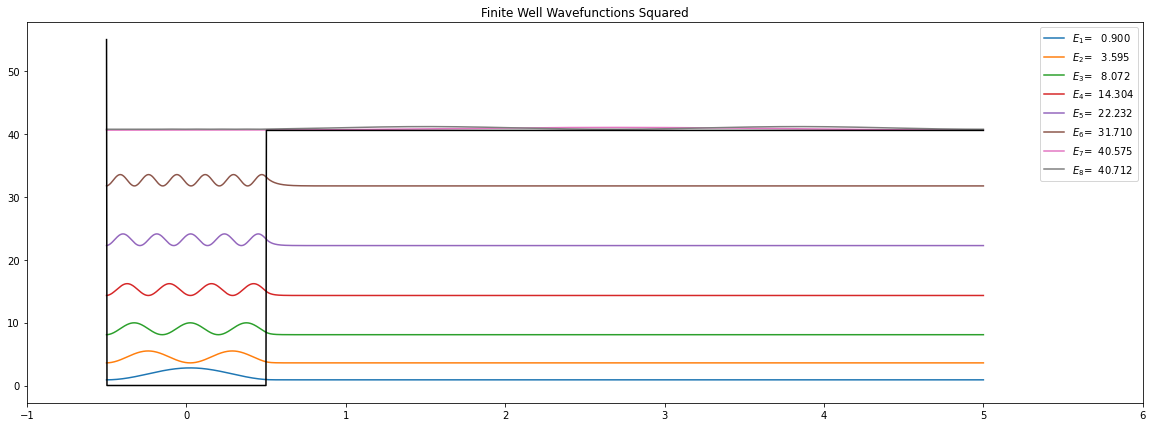

In [56]:
#plot square of wavefunction
V_x =V # potential energy is just zeros. We don't need it for calculating but we do for plotting
for i in range(N): # but adjust potential energy at the ends where it is infinite
    if x[i] == -a/2:
        V_x[i]=1.35*Ea[nl-1] # we can't plot ininity but extend the box to 135% of the highest plotted energy level
plt.figure(figsize=(20,7))
for i in range(nl):
    plt.plot(x,psi_norm[i]**2*fact**2+Ea[i],label="$E_{}$={:>8.3f}".format(i+1,Ea[i]))
plt.title("Finite Well Wavefunctions Squared")
plt.plot(x,V_x,color='black')
plt.xlim(-a,a+bar)
plt.legend()
#plt.savefig("Finite_Square_Well_WaveFunctions_Squared.pdf")
plt.show()

In [61]:
hbar=1 # Planck's constant in atomic units.
m=1 # mass of electron
N = 2047 # number of points to calculate
a = 1.0 # width of finite box
bar=15 # with of barrier
b=20 # total width of system
V0=200 #potential energy in atomic units
Vb=200 #height of barrier
nl=20 #number of levels to calculate
x = np.linspace(-b/2.,b/2.,N) # x-coordinate 
rgtlimit=np.searchsorted(x,[a/2])[0] # find the index of the right edge of the box to be used in integration later.
#searchsorted used here looks through x and finds the value closest to a/2.
# We want to store step size, this is the reliable way:
h = x[1]-x[0] # Should be equal to 2*np.pi/(N-1)

In [62]:
V=[]
for i in x:
  if i>-bar/2 and i<bar/2:
    V.append(Vb)
  elif (i>(-bar/2-a) and i<-bar/2) or (i<(bar/2+a) and i>bar/2):
    V.append(0)
  else:
    V.append(V0)
#print(V)

In [63]:
Mdd = 1./(h*h)*(np.diag(np.ones(N-1),-1) -2* np.diag(np.ones(N),0) + np.diag(np.ones(N-1),1))
H = -(hbar*hbar)/(2.0*m)*Mdd + np.diag(V) 
Ed,psiT = np.linalg.eigh(H) # This computes the eigen values and eigenvectors
psi = np.transpose(psiT)  # We take the transpose of psiT to the wavefunction vectors can accessed as psi[n]
norm=[np.sqrt(1/np.trapz(psi[i]**2,x)) for i in range(nl)] #calcluate normalization coefficient. Should be same but no cost to calculate for each level.
Ed=Ed/np.pi**2*2 # scale energy relative to standard particle in an infinite box
V=[V/np.pi**2*2 for V in V] # same for potential energy.
psi_norm=[psi[i]*norm[i] for i in range(nl)] # normalize 


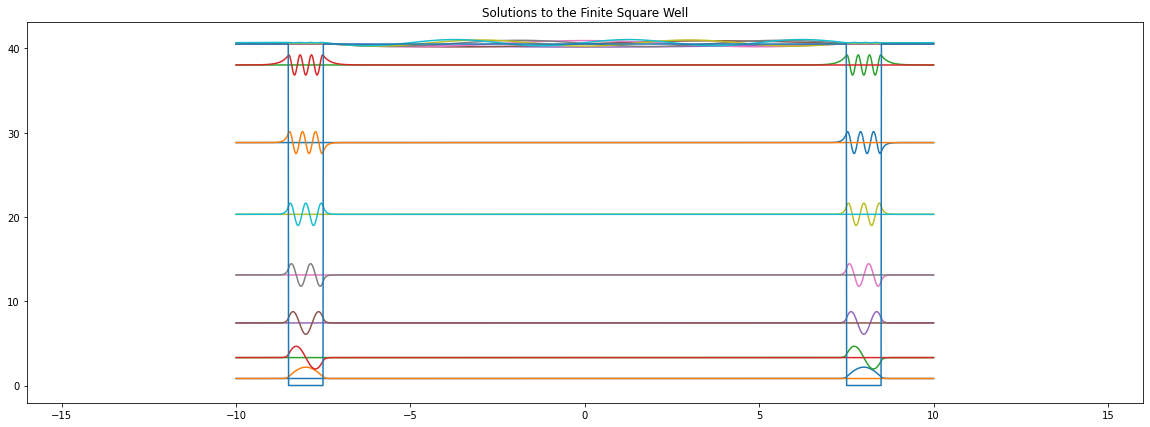

In [64]:
#plot several wavefunctions on same graph with potential. Each one placed at its energy level.
fact=1 #scale factor for nice plotting. 1 does nothing but if the plots need to be scaled up or down, change it.
plt.figure(figsize=(20,7))
for i in range(nl):
    if psi[i][50] < 0:   # Flip the wavefunctions if it is negative at small x, so plots are more consistent.
        plt.plot(x,-psi_norm[i]*fact+Ed[i],label="$E_{}$={:>8.3f}".format(i+1,Ed[i]))
    else:
        plt.plot(x,psi_norm[i]*fact+Ed[i],label="$E_{}$={:>8.3f}".format(i+1,Ed[i]))
    plt.title("Solutions to the Finite Square Well")

plt.plot(x,V)
plt.xlim(-(a+bar),(a+bar))
#plt.legend()
#plt.savefig("Finite_Square_Well_WaveFunctions.pdf")
plt.show()

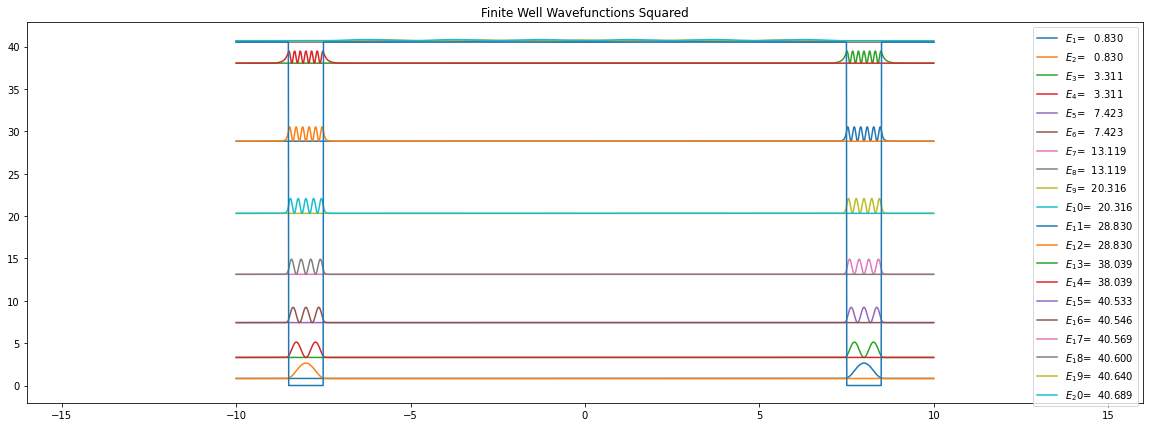

In [65]:
#plot square of wavefunction
plt.figure(figsize=(20,7))
for i in range(nl):
    plt.plot(x,psi_norm[i]**2*fact**2+Ed[i],label="$E_{}$={:>8.3f}".format(i+1,Ed[i]))
plt.title("Finite Well Wavefunctions Squared")
plt.plot(x,V)
plt.xlim(-a-bar,a+bar)
plt.legend()
#plt.savefig("Finite_Square_Well_WaveFunctions_Squared.pdf")
plt.show()

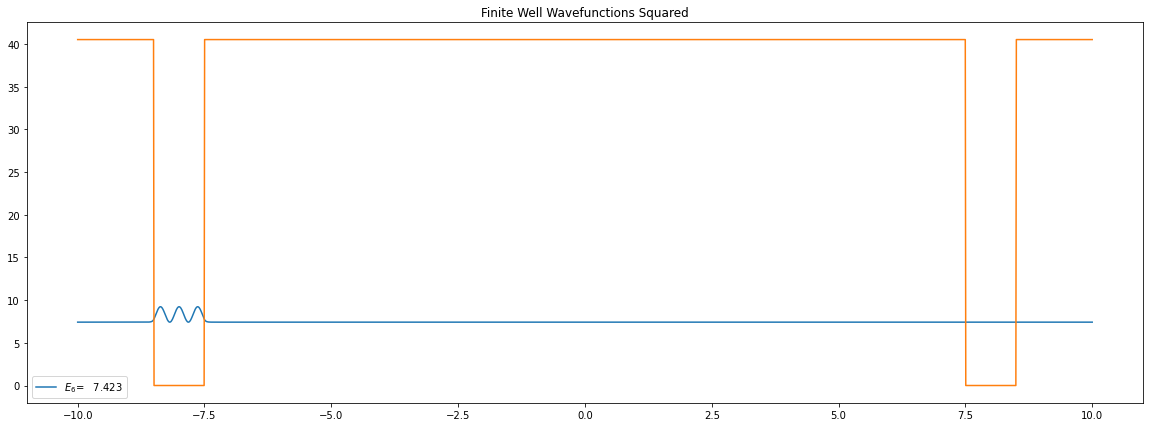

In [73]:
#@title Default title text
l = 5 #@param {type:"slider", min:0, max:15, step:1}
#plot square of wavefunction
plt.figure(figsize=(20,7))
plt.plot(x,psi_norm[l]**2*fact**2+Ed[l],label="$E_{}$={:>8.3f}".format(l+1,Ed[l]))
plt.title("Finite Well Wavefunctions Squared")
plt.plot(x,V)
plt.legend()
#plt.savefig("Finite_Square_Well_WaveFunctions_Squared.pdf")
plt.show()